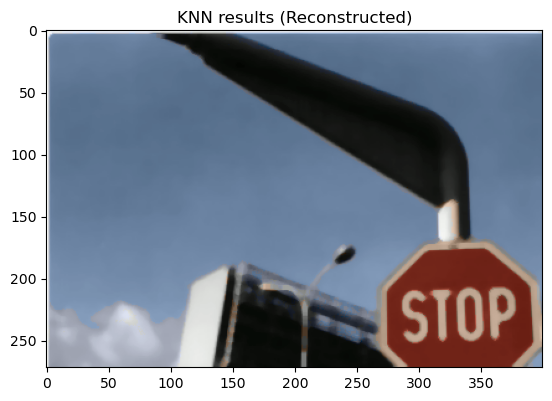

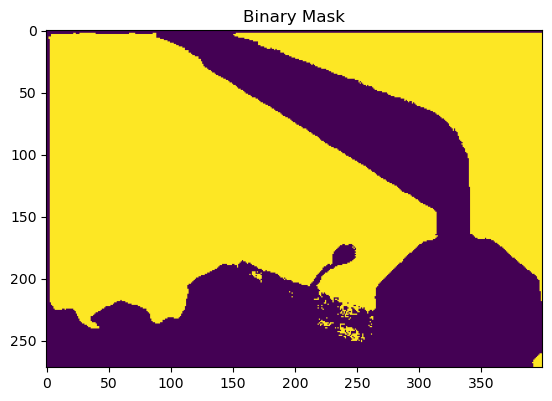

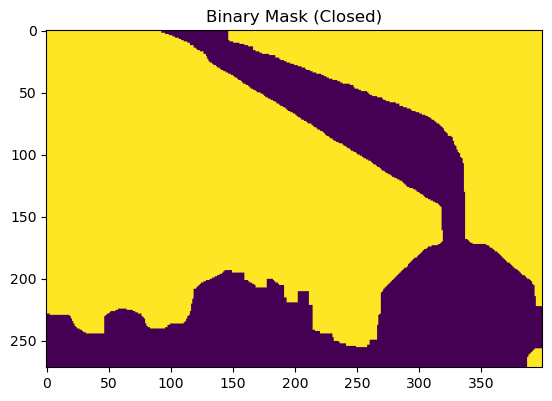

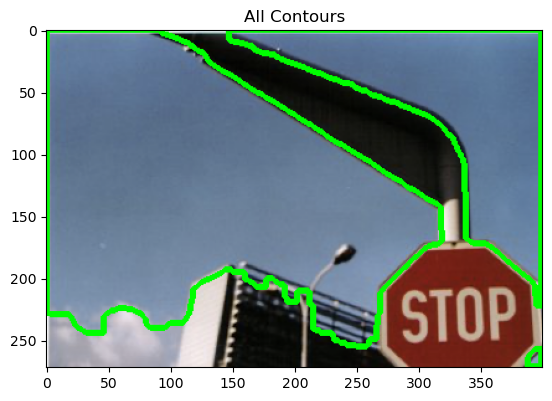

0.8 0.996309963099631
1.1345291479820627 0.6828547153780798
1.25 0.8775057495636855


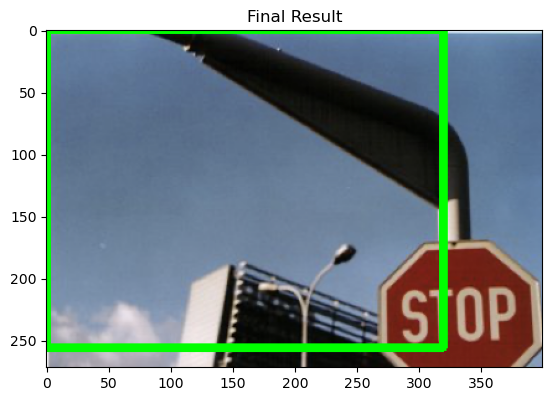

In [53]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# insomma: 3, 17
# img stronze v2: 16, 23
# NON VANNO 4
dir_path = './images/'
i = 8
img_name = f'stop{i}.png'
img_path = os.path.join(dir_path, img_name)
img = cv2.imread(img_path)

# apply median filter to remove noise
img_medianfiltered = cv2.medianBlur(img, ksize=7)

# convert to LAB image 
img_lab = cv2.cvtColor(img_medianfiltered, cv2.COLOR_BGR2LAB)

# select the A and B channels
ab_channel = img_lab[:, :, 1:3]

# plot only the A channel
#plt.imshow(ab_channel)
#plt.title("LAB Image (A channel)")
#plt.show()

# Apply Histogram Equalization
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#a_channel = clahe.apply(a_channel)
#plt.imshow(a_channel)
#plt.title("LAB Image (A channel)")
#plt.show()

# flatten the image to perform k-means clustering
flat_img = ab_channel.reshape((-1, 2))
# convert to float32, required by k-means
flat_img = np.float32(flat_img)

# criteria for k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5

# perform k-means clustering
ret,label,center=cv2.kmeans(
    flat_img,
    K,
    None,
    criteria,
    10,
    cv2.KMEANS_PP_CENTERS
)

# convert the centers to uint8
center = np.uint8(center)

# plot 
res = center[label.flatten()]
res2 = res.reshape((ab_channel.shape))
a_clustered = res2[:, :, 0]
b_clustered = res2[:, :, 1]
l_channel = img_lab[:, :, 0]


lab_reconstructed = cv2.merge((l_channel, a_clustered, b_clustered))
rbg_reconstructed = cv2.cvtColor(lab_reconstructed, cv2.COLOR_LAB2RGB)
plt.imshow(rbg_reconstructed)
plt.title('KNN results (Reconstructed)')
plt.show()


# select the cluster with the maximum a* value (red color)
scores = center[:, 0] - np.abs(center[:, 1] - 128)
cluster_id = np.argmax(scores)

# create a binary mask for the red cluster
mask_flat = np.where(label.flatten() == cluster_id, 255, 0).astype(np.uint8)

# reshape the mask to the original image dimensions
mask = mask_flat.reshape((img_lab.shape[0], img_lab.shape[1]))

# show the binary mask
plt.imshow(mask)
plt.title("Binary Mask")
plt.show()

# apply morphological operations
k_size = max(3, (img.shape[0] // 50) | 1) 
kernel = np.ones((k_size, k_size), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=2)
# apply "Closing" to fill holes and merge fragments
mask_curata = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# show the binary mask
plt.imshow(mask_curata)
plt.title("Binary Mask (Closed)")
plt.show()

# find contours
contours, hierarchy = cv2.findContours(mask_curata, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# convert to RGB image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_contours = img_rgb.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 3)

plt.imshow(img_contours)
plt.title("All Contours")
plt.show()

img_boxes = img_rgb.copy()

best_contour = None
max_area = 0

for cnt in contours:
    area = cv2.contourArea(cnt)
    
    if area > 100: 
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        
        # find the convex hull and calculate the solidity
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        
        # avoid division by zero
        if hull_area > 0:
            solidity = float(area) / hull_area
            print(aspect_ratio, solidity)
            
            # the signle sign must be a square and solid
            if 0.64 <= aspect_ratio <= 1.36 and solidity > 0.65:
                
                if area > max_area:
                    max_area = area
                    best_contour = cnt

# draw the best contour
x, y, w, h = cv2.boundingRect(best_contour)
cv2.rectangle(img_boxes, (x, y), (x+w, y+h), (0, 255, 0), 5)
plt.imshow(img_boxes)
plt.title("Final Result")
plt.show()

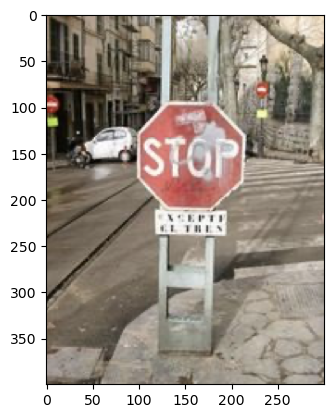

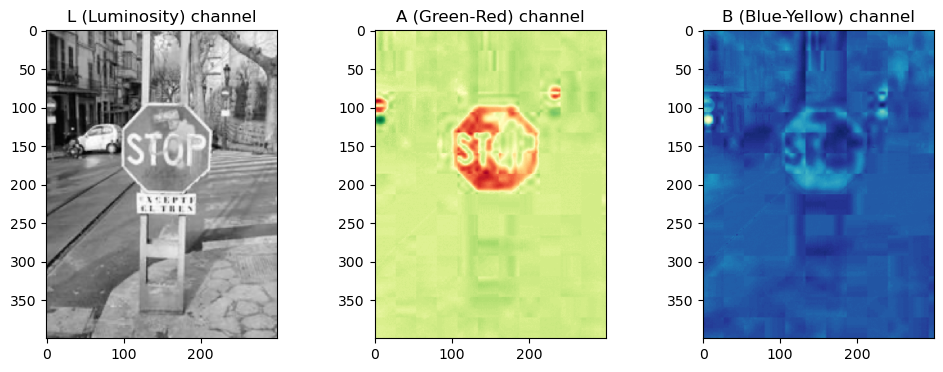

In [30]:
def show_images(img1, img2):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.title('Median Filtered Image')
    plt.imshow(img2)
    plt.show()


def show_images(img1, img2):  
    plt.imshow(img1) # crazy colors
    plt.show()
    # split LAB image into luminosity, green-red, blue-yellow channels
    L, A, B = cv2.split(img2)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('L (Luminosity) channel')
    plt.imshow(L, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('A (Green-Red) channel')
    plt.imshow(A, cmap='RdYlGn_r') 

    plt.subplot(1, 3, 3)
    plt.title('B (Blue-Yellow) channel')
    plt.imshow(B, cmap='YlGnBu_r') 

    plt.show()

dir_path = './images/'
i = 23
img_name = f'stop{i}.png'
img_path = os.path.join(dir_path, img_name)
img = cv2.imread(img_path)

# convert and show RGB image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

show_images(img_rgb, img_lab)

In [8]:
"""
UNI_kmeans.py
GR5293 Applied Machine Learning for Computer Vision - Homework #1

Description:
    Uses K-means color clustering (cv2.kmeans) in the CIELAB color space 
    to detect and localize stop signs in diverse road images.
    The algorithm features dynamic kernels, geometric contour filtering 
    (solidity and aspect ratio) to isolate the octagonal shape, and 
    a custom redness score to handle shadows and backlighting.
"""

import cv2
import time
import os
import numpy as np

def get_box(img):
    """
    Detects the stop sign in the provided image using K-means clustering.
    
    Parameters:
    -----------
    img : numpy.ndarray
        The input image loaded via cv2.imread() in BGR format.
        
    Returns:
    --------
    xmin, ymin, xmax, ymax : int
        The coordinates of the bounding box surrounding the stop sign.
        Returns 0, 0, 0, 0 if no valid stop sign is detected.
    """
    # 1. PREPROCESSING
    # Apply median blur to reduce salt-and-pepper noise while preserving edges
    img_medianfiltered = cv2.medianBlur(img, ksize=7)
    
    # Convert to CIELAB color space for perceptual uniformity (as per course notes)
    img_lab = cv2.cvtColor(img_medianfiltered, cv2.COLOR_BGR2LAB)
    
    # Extract only a* (Green-Red) and b* (Blue-Yellow) channels to ignore lighting (L*)
    ab_channel = img_lab[:, :, 1:3]
    
    # 2. K-MEANS CLUSTERING
    # Flatten the image array for clustering and convert to float32
    flat_img = ab_channel.reshape((-1, 2))
    flat_img = np.float32(flat_img)
    
    # Set termination criteria and number of clusters (K=5 handles shadows well)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 5
    ret, label, center = cv2.kmeans(flat_img, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # 3. CLUSTER SELECTION (Custom Redness Score)
    # Pure red in LAB has high a* and b* close to neutral (128). 
    # This score penalizes yellowish/orange hues (sunsets) where b* is very high.
    scores = center[:, 0] - np.abs(center[:, 1] - 128)
    cluster_id = np.argmax(scores)
    
    # Create a binary mask for the chosen "red" cluster
    mask_flat = np.where(label.flatten() == cluster_id, 255, 0).astype(np.uint8)
    mask = mask_flat.reshape((img_lab.shape[0], img_lab.shape[1]))
    
    # 4. MORPHOLOGICAL CLEANUP
    # Calculate a dynamic kernel size based on image resolution (always odd)
    k_size = max(3, (img.shape[0] // 50) | 1)
    kernel = np.ones((k_size, k_size), np.uint8)
    
    # NEW IDEA FROM CLAUDE: Morphological Opening to remove small background noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Dilate to capture the white borders of the stop sign
    mask = cv2.dilate(mask, kernel, iterations=2)
    
    # Morphological Closing to fill holes (like white text) inside the sign
    mask_curata = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 5. CONTOUR EXTRACTION & GEOMETRIC FILTERING
    contours, hierarchy = cv2.findContours(mask_curata, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    best_contour = None
    max_area = 0
    
    # Iterate through contours to find the one matching a Stop Sign shape (octagon/square)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100: 
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h
            
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            
            if hull_area > 0:
                solidity = float(area) / hull_area
                
                # Filter by aspect ratio (near 1.0) and solidity (convex shape)
                if 0.60 <= aspect_ratio <= 1.40 and solidity > 0.55:
                    if area > max_area:
                        max_area = area
                        best_contour = cnt

    # 6. BOUNDING BOX CALCULATION
    if best_contour is not None:
        x, y, w, h = cv2.boundingRect(best_contour)
        
        # Add a 5% padding to ensure the whole sign is enclosed
        pad = int(w * 0.05)
        xmin = max(0, x - pad)
        ymin = max(0, y - pad)
        xmax = min(img.shape[1], x + w + pad)
        ymax = min(img.shape[0], y + h + pad)
        
        return xmin, ymin, xmax, ymax
    
    # Fallback if nothing is found
    return 0, 0, 0, 0

# --- DO NOT MODIFY MAIN BLOCK BEYOND THIS POINT ---
if __name__ == "__main__":
    start_time = time.time()
    dir_path = './images/'
    
    # Ensure results directory exists
    if not os.path.exists('./results/'):
        os.makedirs('./results/')

    for i in range(1, 25):
        img_name = f'stop{i}.png'
        img_path = os.path.join(dir_path, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            continue
            
        # Get the coordinators of the box
        xmin, ymin, xmax, ymax = get_box(img)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        output_path = f'./results/{img_name}'
        cv2.imwrite(output_path, img)

    end_time = time.time()
    # It usually takes about 10s
    print(f"Running time: {end_time - start_time} seconds")

Running time: 2.8417131900787354 seconds
